# Linear Regression



In [4]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt 
import random

We
should
vectorize the calculations and leverage
fast linear algebra libraries
rather than writing costly for-loops in Python.
Consider two methods for adding vectors

In [5]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

We add them, one coordinate at a time,
using a for-loop

In [6]:
class Timer: #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        self.tlk = time.time()
        
    def stop(self):
        self.times.append(time.time()-self.tlk)
        return self.times[-1]
    
    def avg(self):
        return sum(self.times)/len(self.times)
    
    def sum(self):
        return sum(self.times)
        
    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

In [7]:
c =torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i]= a[i]+b[i]
f'{timer.stop():.5f} sec'

'0.03372 sec'

In [8]:
c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
f'{time.time() - t:.5f} sec'

'0.03010 sec'

Alternatively, we rely on the reloaded `+` operator to compute the elementwise sum

In [9]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00019 sec'

We define a function to compute the normal distribution

In [10]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

Visualize the normal distributions

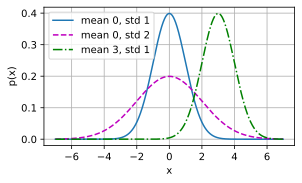

In [11]:
x = np.arange(-7, 7, 0.01)

params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

In [12]:
def synthetic_data(w,b,num_examples): #@save
    """生产y=Xw+b+噪声"""
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w)+b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))

In [13]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)
features.shape
labels.shape

torch.Size([1000, 1])

In [14]:
print('features:',features[0:10],'\nlable:',labels[0:10])

features: tensor([[-0.9930, -0.5714],
        [-0.0244, -0.2377],
        [ 0.2269, -0.4673],
        [-0.9009, -0.3809],
        [-2.1051, -0.1467],
        [-0.7227,  1.4709],
        [ 0.0175,  1.1293],
        [ 0.3150, -1.9709],
        [-0.3101, -0.3996],
        [-0.6865,  0.2981]]) 
lable: tensor([[ 4.1649],
        [ 4.9638],
        [ 6.2591],
        [ 3.7025],
        [ 0.4829],
        [-2.2506],
        [ 0.4037],
        [11.5239],
        [ 4.9370],
        [ 1.8303]])


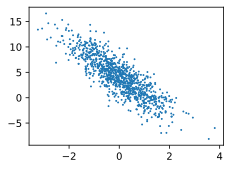

In [16]:
d2l.set_figsize()
plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)

In [17]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices =list(range(num_examples))
    random.shuffle(indices) 
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]
    

In [18]:
batch_size =10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 0.8929, -0.4707],
        [-0.5120,  0.3670],
        [-2.6208, -0.1228],
        [ 0.9998, -0.1823],
        [ 0.8626, -0.6401],
        [-2.6457, -0.0467],
        [-0.1675, -0.3224],
        [-0.9560,  0.7258],
        [ 0.3216, -1.5834],
        [-0.0275,  0.3476]]) 
 tensor([[ 7.5838],
        [ 1.9395],
        [-0.6258],
        [ 6.8052],
        [ 8.1159],
        [-0.9311],
        [ 4.9547],
        [-0.1751],
        [10.2108],
        [ 2.9501]])


In [19]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [20]:
def linreg(X,w,b): #@save
    """线性回归模型"""
    return torch.matmul(X,w)+b

In [21]:
def squared_loss(y_hat,y):  #@save
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [22]:
def sgd(params,lr,batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            

In [29]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y) # x 和 y 的小批量损失
        # 因为l形状事(batch_size,1),而不是一个标量。l中的所有元素被加到一起，并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000049
epoch 2, loss 0.000049
epoch 3, loss 0.000049


In [30]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')

w的估计误差：tensor([ 0.0006, -0.0003], grad_fn=<SubBackward0>)


In [31]:
print(f'b的估计误差: {true_b-b}')

b的估计误差: tensor([-0.0002], grad_fn=<RsubBackward1>)


In [32]:
# softmax 回归的从零开始实现
import torch
from IPython import display
from d2l import torch as d2l

In [33]:
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)

In [34]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

In [35]:
X =torch.tensor([[1.0,2.0,3.0],[4.0,5.0,6.0]])
X.sum(0,keepdim=True),X.sum(1,keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [36]:
def softmax(X):
    X_exp=torch.exp(X)
#     print(X_exp)
    partition = X_exp.sum(1,keepdim=True)
#     print(partition)
    return X_exp/partition # 这里使用了广播机制

In [37]:
X = torch.normal(0,1,(2,5))
X_prob =softmax(X)
X_prob,X_prob.sum(1)

(tensor([[0.0291, 0.2590, 0.5207, 0.0240, 0.1672],
         [0.2391, 0.0052, 0.0069, 0.7157, 0.0332]]),
 tensor([1., 1.]))

In [38]:
# 定义模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W)+b)

In [39]:
y =torch.tensor([0,2])
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
print(y)
print(y_hat)
y_hat[[0,1],y]

tensor([0, 2])
tensor([[0.1000, 0.3000, 0.6000],
        [0.3000, 0.2000, 0.5000]])


tensor([0.1000, 0.5000])

In [40]:
def cross_entropy(y_hat,y):
    return - torch.log(y_hat[range(len(y_hat)),y])

In [41]:
cross_entropy(y_hat,y)

tensor([2.3026, 0.6931])

In [42]:
def accuracy(y_hat,y): #@save
    """计算预测正确的数量"""
    if len(y_hat.shape)>1 and y_hat.shape[1] > 1:
        y_hat=y_hat.argmax(axis=1)
    cmp=y_hat.type(y.dtype)== y
    return float(cmp.type(y.dtype).sum())

In [43]:
accuracy(y_hat,y)/len(y)

0.5

In [44]:
def evaluate_accuracy(net,data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net,torch.nn.Module):
        net.eval() #将模型设置为评估模式
    metric = Accumulator(2) #正确预测数，预测总数
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [45]:
class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self,n):
        self.data= [0.0]*n
    
    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]
        
    def reset(self):
        self.data = [0.0]*len(self.data)
        
    def __getitem__(self,idx):
        return self.data[idx]

In [46]:
evaluate_accuracy(net,test_iter)

0.0853

In [110]:
def train_epoch_ch3(net,train_iter,loss,updater): #@save
    """训练模型一个迭代周期（定义见第三章）"""
    #将模型设置为训练模式
    if isinstance(net,torch.nn.Module):
        net.train()
    # 训练损失综合，训练准确的总和、样本数
    metric = Accumulator(3)
    for X,y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l=loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            # 使用pytorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            #使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    # 返回训练损失和训练精度
    return metric[0]/metric[1],metric[1]/metric[2]
        
    

In [111]:
class Animator: #@save
    """在动画中绘制数据"""
    def __init__(self,xlabel=None,ylabel=None,legend=None,xlim=None,ylim=None,xscale='linear',yscale='linear',fmts=
                ('-','m--','g-','r:'),nrows=1,ncols=1,figsize=(3.5,2.5)):
        # 增量绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig,self.axes=d2l.plt.subplots(nrows,ncols,figsize=figsize)
        if nrows*ncols ==1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获函数
        self.config_axes=lambda:d2l.set_axes(self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)
        self.X,self.Y,self.fmts=None,None,fmts
    def add(self,x,y):
        # 向图中添加多个数据点
        if not hasattr(y,"__len__"):
            y=[y]
        n = len(y)
        if not hasattr(x,"__len__"):
            x =[x]*n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i,(a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x,y,fmt in zip(self.X,self.Y,self.fmts):
            self.axes[0].plot(x,y,fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
            

In [113]:
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater): #@save
    """训练模型（定义见第三章）"""
    animator = Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,0.9],legend=['train loss','train acc','train acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net,train_iter,loss,updater)
        test_acc = evaluate_accuracy(net,test_iter)
        animator.add(epoch+1,train_metrics+(test_acc,))
    train_loss,train_acc=train_metrics
    assert train_loss<0.5,train_loss
    assert train_acc<=1 and train_acc>0.7,train_acc
    assert train_acc<=1 and train_acc>0.7,test_acc

In [114]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W,b],lr,batch_size)


AssertionError: nan

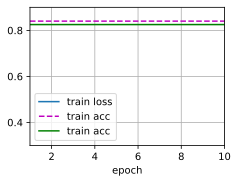

In [116]:
num_epochs = 10
train_ch3(net,train_iter,test_iter,cross_entropy,num_epochs,updater)

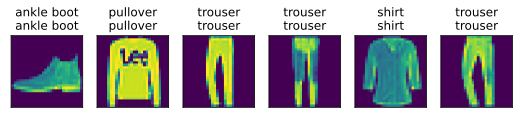

In [117]:
def predict_ch3(net,test_iter,n=6): #@save
    """预测标签"""
    for X,y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true,pred in zip(trues,preds)]
    d2l.show_images(X[0:n].reshape((n,28,28)),1,n,titles=titles[0:n])
    
predict_ch3(net,test_iter)

In [120]:
# softmax回归的简洁实现
import torch
from torch import nn 
from d2l import torch as d2l

batch_size =128
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)

# 初始化模型参数
# pytorch 不会隐式地调整输入的形状。因此我们在线性层定义了展平层(flatten()),来调整网络输入的形状
net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))

def init_weight(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
        
net.apply(init_weight);

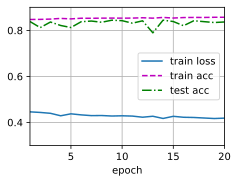

In [122]:
loss =nn.CrossEntropyLoss(reduction='none')

trainer = torch.optim.SGD(net.parameters(),lr=0.2)
num_epochs = 20
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)